In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine) 

In [9]:
conn = engine.connect()

In [10]:
measure = pd.read_sql("select * from measurement", conn)


In [11]:
measure.head()


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [12]:
inspector = inspect(engine)

In [13]:
station = inspector.get_columns("station")
for st in station:
    print(st)
    print(st["name"], st["type"])

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
id INTEGER
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
station TEXT
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
name TEXT
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
latitude FLOAT
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
longitude FLOAT
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
elevation FLOAT


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23')

In [15]:
# Calculate the date one year from the last date in data set.
last_year_date = dt.date(2017,8,23)- dt.timedelta(days= 364)
last_year_date

datetime.date(2016, 8, 24)

In [16]:
lastyear_startdate = (dt.datetime.strptime(recent_date[0],'%Y-%m-%d') - dt.timedelta(days=364)).strftime('%Y-%m-%d')
print(f'The start date for the last year of data is {lastyear_startdate}')

The start date for the last year of data is 2016-08-24


<AxesSubplot:xlabel='date'>

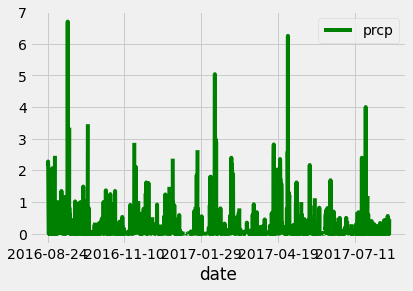

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores
most_recent_prec = session.query(measurement.date,measurement.prcp).filter(measurement.date >= lastyear_startdate).all()
most_recent_prec
# Save the query results as a Pandas DataFrame and set the index to the date column
most_recent_df = pd.DataFrame(most_recent_prec)
most_recent_df
# Sort the dataframe by date

most_recent_df.set_index('date', inplace= True)
most_recent_df

# Sort the DataFrame
sorted_most_recent_prep = most_recent_df.sort_index()
sorted_most_recent_prep
# Use Pandas Plotting with Matplotlib to plot the data
sorted_most_recent_prep.plot(color = "green")



In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_most_recent_prep.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
total_station = session.query(measurement.station).group_by(measurement.station).count()
total_station

9

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = session.query(measurement.station, func.count(measurement.date)).\
                 group_by(measurement.station).order_by(func.count(measurement.date).desc()).all()
active_station
most_active_station = session.query(measurement.station, func.count(measurement.date)).\
                 group_by(measurement.station).order_by(func.count(measurement.date).desc()).first()

most_active_station_id = most_active_station[0]
most_active_station_id
#active_station_df = pd.DataFrame(active_station)

'USC00519281'

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_most_active = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active_station_id).scalar()
print(lowest_most_active)

highest_most_active = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active_station_id).scalar()
print(highest_most_active)

avg_most_active = session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active_station_id).scalar()

print(avg_most_active)

54.0
85.0
71.66378066378067


Text(0.5, 0, 'Temperature (F)')

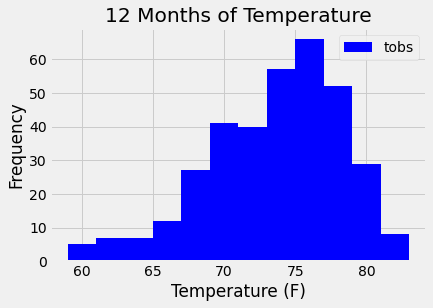

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_data = session.query(measurement.tobs).\
            filter(measurement.date >= lastyear_startdate, measurement.station == most_active_station_id).all()

year_data_df = pd.DataFrame(year_data)
year_data_df


year_data_df.plot.hist(bins = 12, color = "blue" )
plt.title("12 Months of Temperature")
plt.xlabel("Temperature (F)")

# Close session

In [23]:
# Close Session
session.close()